In [1]:
%load_ext autoreload

%autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train
import Tomita_Grammars 
from RNN2DFA.Training_Functions import make_test_set,make_train_set_for_target
from RNNexplainer import Explainer
import pandas as pd
import LTL2DFA as ltlf2dfa
from RNN2DFA.Extraction import extract





In [2]:
# Reber grammar
from specific_examples import Reber_Grammar
rg=Reber_Grammar()
alphabet=rg.alphabet
generator_dfa=rg
sample_train_set=[]
for i in range(100):
    seq, _, _ = rg.get_one_example(maxLength=10)
    sample_train_set.append(seq)
    # print(rg.classify_word(rg.sequenceToWord(seq)))

In [3]:
import specific_examples
generator_dfa=specific_examples.Example9()
target_formula = generator_dfa.target_formula
alphabet = generator_dfa.alphabet
query_formulas = generator_dfa.query_formulas


In [4]:
from sklearn.model_selection import train_test_split
def dict2lists(dictionary):
    X,y=[],[]
    for key in dictionary:
        X.append(key)
        y.append(dictionary[key])
    return X,y

def lists2dict(x,y):
    # both x and y should have same length
    assert len(x)==len(y), "Error dimension"
    d={}
    n=len(x)
    for idx in range(n):
        d[x[idx]]=y[idx]
    return d

# for each example, specify a different generating function


if(target_formula == "balanced parentheses"):
    train_set = generator_dfa.get_balanced_parantheses_train_set(100, 2, 50,max_train_samples_per_length=300,                                                         search_size_per_length=20,lengths=[i+1 for i in range(50)])
    

elif(target_formula == "email match"):
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i+1 for i in range(50)],
                                          max_train_samples_per_length=1000,
                                          search_size_per_length=3000, deviation = 20)

    # generate more examples that match the regular expression
    matching_strings = generator_dfa.generate_matching_strings(
        n=1080, max_length=50)
    for string in matching_strings:
        train_set[string] = True
    
    

elif(target_formula == "alternating bit protocol"):
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i+1 for i in range(50)],
                                          max_train_samples_per_length=100,
                                          search_size_per_length=30, deviation = 25)

    # generate more examples that match the regular expression
    matching_strings = generator_dfa.generate_matching_strings(
        n=1050, max_sequence_length=50)
    for string in matching_strings:
        train_set[string] = True

else:
    train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet,lengths=[i for i in range(51)],
                                          max_train_samples_per_length=100,
                                          search_size_per_length=300, deviation = 20)


    

# print ratio
cnt = 0
examples_per_length=[0 for i in range(51)]
for key in train_set:
    if(train_set[key]):
        cnt += 1
    examples_per_length[len(key)] += 1

total_samples = len(train_set) 
print("out of ", total_samples, " sequences", cnt , " are positive. (percent: ", float(cnt/total_samples), ")")
print("examples per length:", examples_per_length)
    
# split train:test
X, y = dict2lists(train_set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_set = lists2dict(X_train, y_train)
test_set = lists2dict(X_test, y_test)
print("size of train set:", len(train_set))
print("size of test set:", len(test_set))

made train set of size: 981 , of which positive examples: 6
out of  981  sequences 6  are positive. (percent:  0.0061162079510703364 )
examples per length: [1, 3, 9, 22, 22, 22, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
size of train set: 784
size of test set: 197


In [5]:
# intentionally pushing "" (empty string) in train_set
if('' not in train_set):
    train_set['']=test_set['']
print("size of train set:", len(train_set))
print("size of test set:", len(test_set))

size of train set: 784
size of test set: 197


In [6]:
fout=open("output/log.txt", "a")
fout.write(".........................................................................\n")
fout.write("Target: "+ target_formula)
print(target_formula)
fout.write("\n")
fout.close()


# define rnn
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


# train the model
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)
rnn.renew()  
dfa_from_rnn=rnn 
# statistics

def percent(num,digits=2):
    tens = pow(10,digits)
    return int(100*num*tens)/tens

print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = 0
rnn_target = 0
for w in test_set:
    if generator_dfa.classify_word(w):
        pos+=1

    if dfa_from_rnn.classify_word(w)==generator_dfa.classify_word(w):
        rnn_target+=1
print("rnn score against target on test set:                             ",rnn_target,"("+str(percent(rnn_target/n))+")")
test_set_size= len(test_set)
test_acc = percent(rnn_target/test_set_size)

# dfa_from_rnn=generator_dfa

G(a)
The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
current average loss is:  0.008859970459016039
current average loss is:  0.0034861589447245933
current average loss is:  0.0017578780677649775
current average loss is:  0.0010071674867958794
current average loss is:  0.0006580605686099262
current average loss is:  0.0005705674007839086
classification loss on last batch was: 0.0004983293082641096
testing on train set, i.e. test set is train set
test set size: 197
rnn score against target on test set:                              197 (100.0)


true


positive traces---> 
[]


negative traces---> 
[]



Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: true
Learning took:  0.04714703559875488  s
EQ test took  0.003036975860595703  s
new counterexample:   should be rejected by implementation


positive traces---> 
[]


negative traces---> 
['']



0  iteration complete



Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: false
Learning took:  0.04397392272949219  s
EQ test took  0.10227084159851074  s
new counterexample: a  should be accepted by implementation


positive traces---> 
['a']


negative traces---> 
['']



1  iteration complete



start formula depth: 1
Before normalization: x0
Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: a
Learning took:  0.12409114837646484  s
EQ test took  0.11619377136230469  s
new counterexample: ac  should be rejected by implementation


positive traces---> 
['a']


negative traces---> 
['', 'ac']



2  iterat

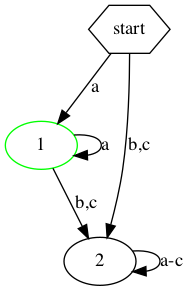

doing minimization from  3  states to  3  states


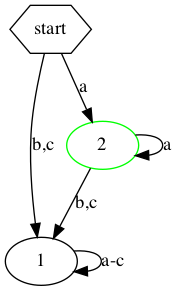


Time taken to extract lstar-dfa: 0.1973419189453125
returned flag: True
transitions:->
number of states of the dfa: 3
Explanation matches RNN: 100.0
RNN matches ground truth: 100.0
Explanation matches ground truth: 100.0
Lstar matches RNN: 100.0
Lstar matches ground truth: 100.0


In [7]:
timeout = 15
maximum_sequence_length = 50
maximum_formula_depth = 50
epsilon = 0.05
delta = 0.05

# use a query LTL formula
query_formula="true"
print(query_formula)
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula, token="bal")
# print(query_dfa)
"""  
Create initial samples
"""


from RNNexplainer import Traces
traces=Traces(rnn, alphabet, token="bal")
traces.label_from_network([])
traces.write_in_file()




from PACTeacher.pac_teacher import PACTeacher as Teacher 
explainer=Explainer(alphabet=[character for character in alphabet], token="bal")
teacher = Teacher(dfa_from_rnn,epsilon=.03, delta=.03, max_trace_length=20, max_formula_depth=10, query_dfa=query_dfa)



import time
start_time=time.time()
from multiprocessing import Process, Queue
explainer, flag= teacher.teach(explainer, traces, timeout = 20)
end_time=time.time()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)

fout=open("output/log.txt", "a")
fout.write("\n\nquery: "+query_formula)
fout.write("\nfinal LTL: "+ explainer.ltl)

new_delta = None
new_epsilon = None
if(not flag):
    fout.write(" [incomplete]")
    print("incomplete formula")
    new_delta, new_epsilon = teacher.calculate_revised_delta_and_epsilon()
    print(new_delta, new_epsilon)

fout.write("\n\n")

print("returned counterexamples:", teacher.returned_counterexamples)

print("\nTime taken:", end_time-start_time)
fout.close()


fout=open("output/log.txt", "a")

run_lstar = True
if(run_lstar):
        # compare with dfa from lstar_algorithm
        dfa_from_rnn.renew()
        start_time_lstar = time.time()
        dfa_lstar, lstar_flag = extract(rnn, query=query_dfa, max_trace_length=maximum_sequence_length, epsilon=delta,
                                        delta=delta, time_limit=timeout, initial_split_depth=10, starting_examples=[])
        end_time_lstar = time.time()

        dfa_lstar.draw_nicely(
            filename=target_formula+":"+query_formula+"_"+str(epsilon)+"_"+str(delta))
        dfa_lstar = dfa_lstar.minimize_()
        dfa_lstar.draw_nicely(
            filename=target_formula+":"+query_formula+"_"+str(epsilon)+"_"+str(delta))

        
        print("\nTime taken to extract lstar-dfa:",
                end_time_lstar-start_time_lstar)
        print("returned flag:", lstar_flag)
        print("transitions:->")
        # print(dfa_lstar.delta)
        num_lstar_states = len(dfa_lstar.Q)
        print("number of states of the dfa:", num_lstar_states)


performance_explanation_with_rnn = performance_rnn_with_groundtruth = performance_explanation_with_groundtruth = 0
lstar_performance_explanation_with_rnn = lstar_performance_explanation_with_groundtruth = 0

test_set_size = 0
for w in train_set:

    

    dfa_from_rnn.renew()

    test_set_size += 1
    verdict_rnn = dfa_from_rnn.classify_word(w)
    verdict_target = generator_dfa.classify_word(w)
    verdict_ltl = explainer.dfa.classify_word(w)
    verdict_query = query_dfa.classify_word(w)

    if(run_lstar):
        verdict_lstar = dfa_lstar.classify_word(w)

    if (verdict_rnn and verdict_query) == verdict_ltl:
        performance_explanation_with_rnn += 1
    if verdict_rnn == verdict_target:
        performance_rnn_with_groundtruth += 1
    if verdict_ltl == (verdict_target and verdict_query):
        performance_explanation_with_groundtruth += 1
    if(run_lstar):
        if (verdict_rnn and verdict_query) == verdict_lstar:
            lstar_performance_explanation_with_rnn += 1
        if verdict_lstar == (verdict_target and verdict_query):
            lstar_performance_explanation_with_groundtruth += 1

if(test_set_size != 0):
    print("Explanation matches RNN:", str(
        percent(performance_explanation_with_rnn/test_set_size)))

    print("RNN matches ground truth:", str(
        percent(performance_rnn_with_groundtruth/test_set_size)))

    print("Explanation matches ground truth:", str(
        percent(performance_explanation_with_groundtruth/test_set_size)))

    if(run_lstar):
        print("Lstar matches RNN:", str(
            percent(lstar_performance_explanation_with_rnn/test_set_size)))

        print("Lstar matches ground truth:", str(
            percent(lstar_performance_explanation_with_groundtruth/test_set_size)))

fout.close()

if(not run_lstar):
    num_lstar_states = None
    start_time_lstar = 0
    end_time_lstar = 0
    lstar_performance_explanation_with_rnn = 0
    lstar_performance_explanation_with_groundtruth = 0
    lstar_flag = False


